# Predicting Sales Prices

 ## Dataset Attributes

 The dataset contains information about houses in Ames, Iowa. The data was collected by the Ames City Assessor’s Office describing 2930 property sales which occurred in Ames, Iowa between 2006 and 2010. The dataset, containing 81 variables, was compiled and published by De Cock in 2011.

 Some of the variables contained in the original dataset have been removed from the the dataset provided to you.
 The dataset provided to you contains the following variables:
* **Year_Built:** year that the house was originally constructed
* **Year_Remod_Add:** year that the house was last remodelled
* **Total_Bsmt_SF:** total size of basement area in square feet
* **First_Flr_SF:** size of the first floor in square feet
* **Second_Flr_SF:** size of the second floor in square feet
* **Gr_Liv_Area:** size of above grade, ground living area in square feet
* **Full_Bath:** number of full above grade bathrooms in the house
* **Half_Bath:** number of half above grade bathrooms in the house
* **Bedroom_AbvGr:** number of above grade bedrooms (does not include basement bedrooms)
* **Kitchen_AbvGr:** number of above grade kitchens
* **TotRms_AbvGrd:** total number of above grade rooms (does not include bathrooms)
* **Fireplaces:** number of fireplaces in the house
* **Garage_Area:** size of garage in square feet
* **Sale_Price:** sale price of the house in dollars


*De Cock, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester
Regression Project," Journal of Statistics Education, Volume 19, Number 3.*

- https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
- http://ww2.amstat.org/publications/jse/v19n3/decock.pdf


 ## Objective

 The goal of this task is to analyse the relationship between these variables and build a multiple linear regression model to predict the sales prices based on the 'Gr_Liv_Area' and 'Garage_Area` variables.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Read in the data set
data = pd.read_csv("ames.csv")

# View first 5 rows of data
data.head()

,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
0,1960,1960,1080,1656,0,1656,1,0,3,1,7,2,528,215000
1,1961,1961,882,896,0,896,1,0,2,1,5,0,730,105000
2,1958,1958,1329,1329,0,1329,1,1,3,1,6,0,312,172000
3,1968,1968,2110,2110,0,2110,2,1,3,1,8,2,522,244000
4,1997,1998,928,928,701,1629,2,1,3,1,6,1,482,189900


### Data cleaning

In this section we will check whether the data needs to be cleaned.

In [3]:
# Return a DataFrame to count null values in each column in the dataset
pd.DataFrame({'column_name': column, 'num_null': data[column].isnull().sum()} for column in data.columns )

,column_name,num_null
0,Year_Built,0
1,Year_Remod_Add,0
2,Total_Bsmt_SF,0
3,First_Flr_SF,0
4,Second_Flr_SF,0
5,Gr_Liv_Area,0
6,Full_Bath,0
7,Half_Bath,0
8,Bedroom_AbvGr,0
9,Kitchen_AbvGr,0


This shows that we have a complete dataset. There are no missing values.

### Data distribution

Next, we will check how the data are distributed by poltting a histogram of each variable.

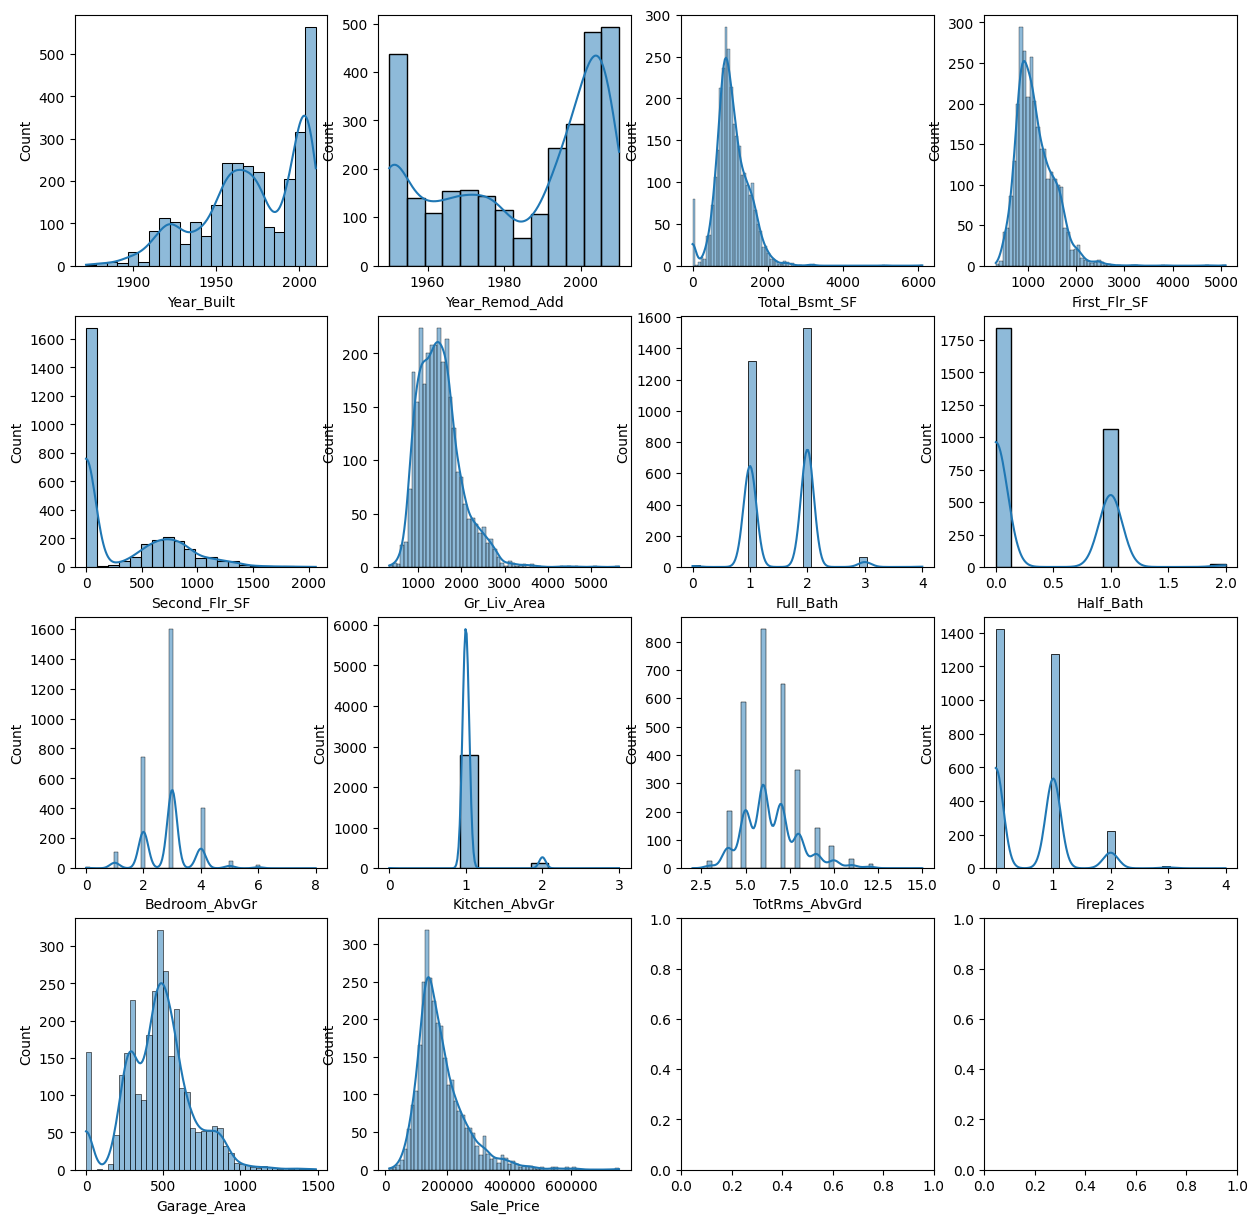

In [4]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for count, column in enumerate(data.columns):
    sns.histplot(data=data, x=column, kde=True, ax=axs[int(count/4), count%4])

In the figure above we can see how the data for each of the variables is distributed. 

We can see that some variables (such as Total_Bsmt_SF and Gr_Liv_Area) are approximatly normal distributions, while others are not.

We can also see that for some variables (such as Kitchen_AbvGr) almost all the records have the same value.


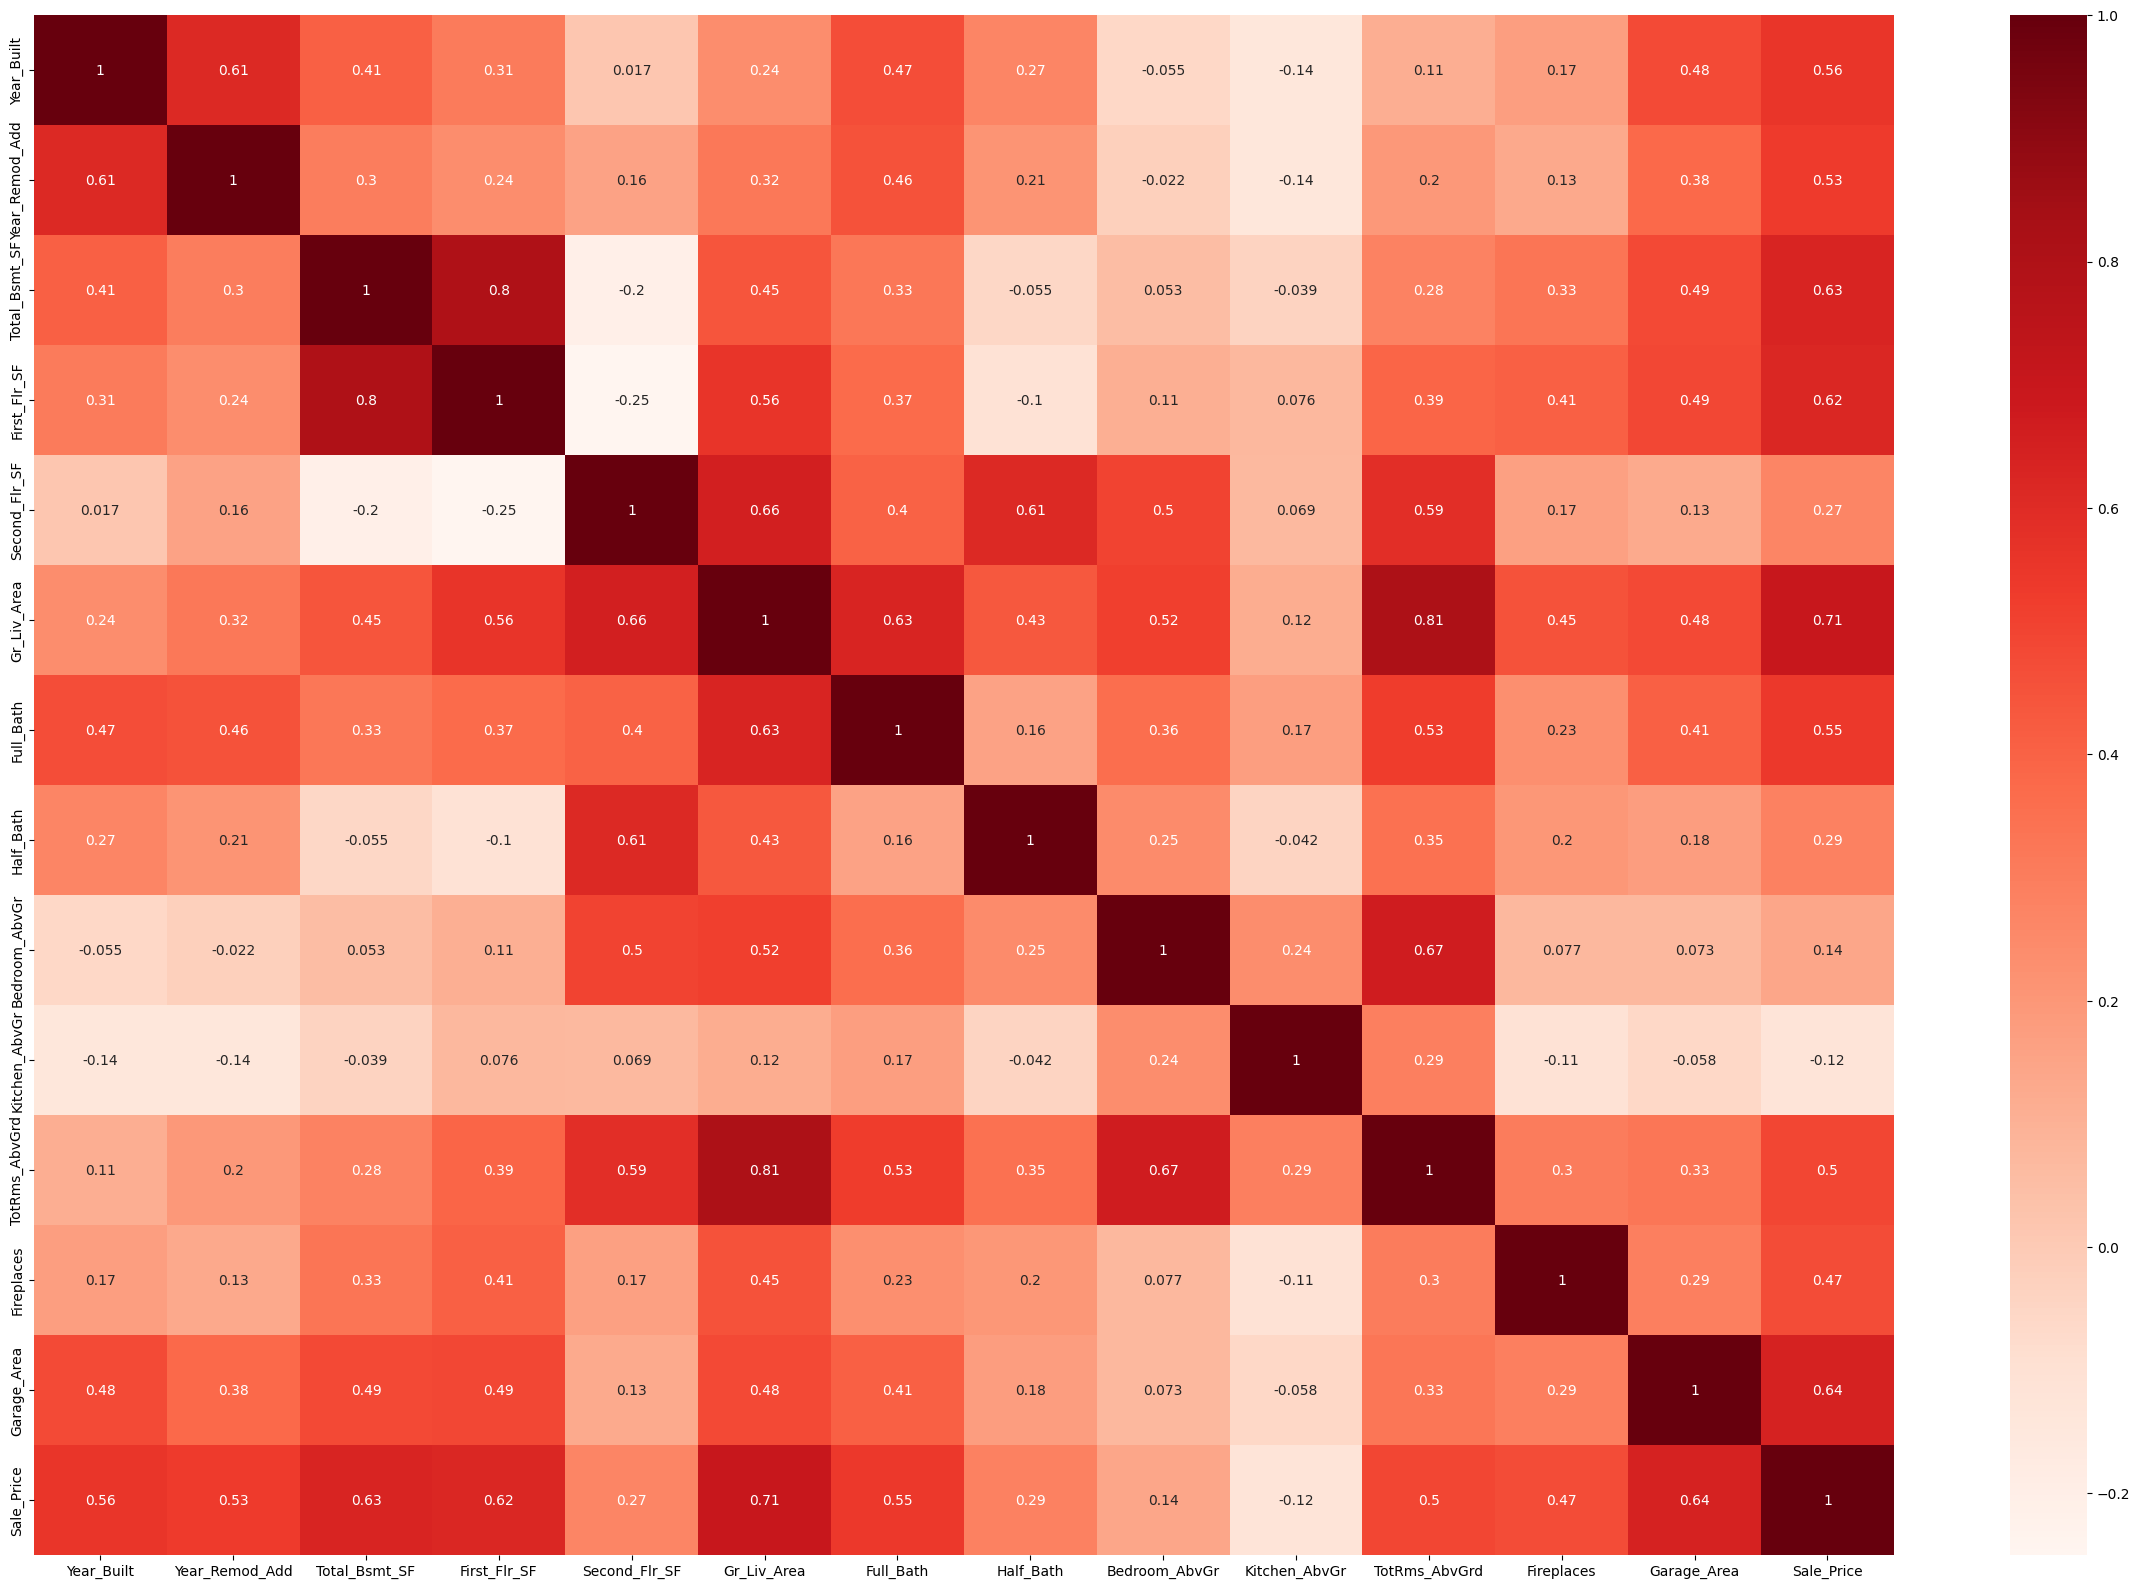

In [5]:
# Display Pearson correlation HeatMap
plt.figure(figsize=(30,20))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Here we are looking so see how strong the correlation is between Sale_Price and all the other variables. To do this we can look at the bottom row. We can see that most varaibles show a correlation with the sale price, with a few exceptions:
- Kitchen_AbvGr is showing as -0.12. This weak correlation is likely because almost all houses have just 1 kitchen. This can be seen in the histogram plot above.
- Bedroom_AbvGr is showing as 0.14. It is not immediatley clear why this is the case, as one would expect the number of bedrooms to correlate well with the house price. 

### Select variables

For the linear regression model use the following dependent variable:
- Sale_Price

and the following independent variables:
- Gr_Liv_Area: size of above grade, ground living area in square feet
- Garage_Area: size of garage in square feet

These variables have been selected since they have the higest correlation coefficents. 
The correlation coefficents for these variables, with Sale_Price are:
| Gr_Liv_Area | Garage_Area |
| ----------- | ----------- |
| 0.71 | 0.64 |

In [16]:
# Split the independent variable from the dependent variables
# y = dependent variable
# X = independent variables

y = data.iloc[:,-1].values
X = data.iloc[:,[5, 12]].values

### Explore relationships

Next we will check the relationships between the dependedent and independent variables and determine the need for scaling. 

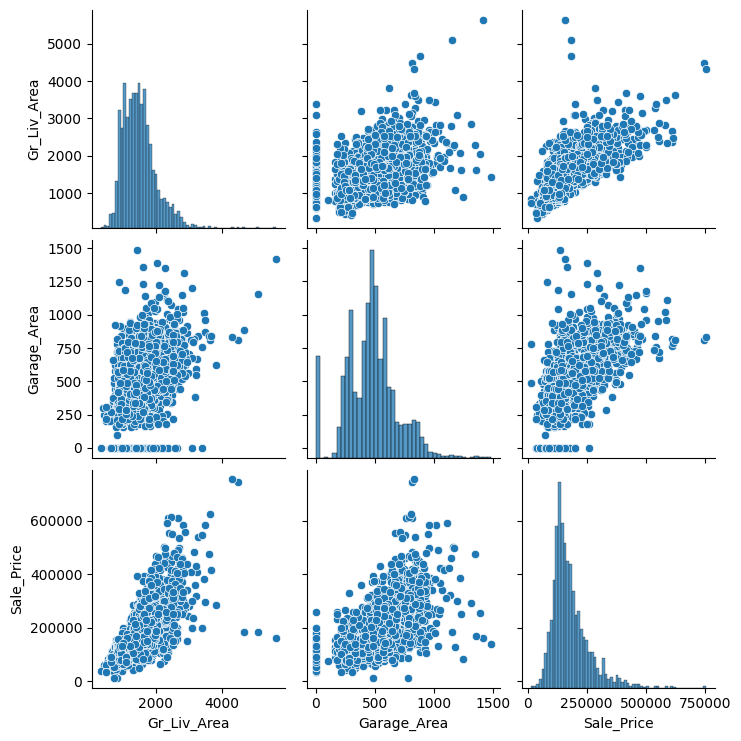

In [17]:
# Explore relationships between the independent and dependent variables

# Plot the distribution of the data
sns.pairplot(data=data.iloc[:,[5,12,13]])

Here we can see that the variables fit a normal distribution fairly well. The main exception to this is that there are a large number of zero values for Garege_Area. These represent houses that do not have a garage. Since these are genuine data points we will not ommit them from our analysis. 

We are now going to scale the data. This is necessary because each of the varaibles has different units and is on on a different scale. By scaling the data we ensure that each of the variables contributes equally to the linear regression model.

The two options for scaling data are standardization and normalization (Min-Max Scaling). 

Standardization is less affected by outliers and is best used when the data is normally distributed.

Normalization can be used for data that is not normally distributed but is heavily affected by outliers. 

Since the data is normally distributed, we will standardize using StandardScaler.


### Select datasets and scale data

Next we will select the datasets and scale the data.

In [18]:
# Create a training and test set with a 75:25 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)


print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_test.shape, y_test.shape)

Training data: (2197, 2) (2197,)
Test data: (733, 2) (733,)


In [19]:
# Fit the scaler on train data
scalar = StandardScaler()
scalar.fit(X_train)

# Apply the scaler on train and test data
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [26]:
# Build a multiple linear regression model using 'Gr_Liv_Area' and 'Garage_Area'

progression_model = LinearRegression()
progression_model.fit(X_train,y_train)


# Print the model intercept and coefficients

print('Intercept: \n', progression_model.intercept_)
print('Coefficients: \n', progression_model.coef_)

Intercept: 
 181064.06599908968
Coefficients: 
 [43170.68293337 29770.92010104]


In [28]:
# Generate predictions for the test set
y_predictions = progression_model.predict(X_test)

In [29]:
# Evaluate the model
# Get values for the error bar
error_bar_values = np.abs((y_test-y_predictions))

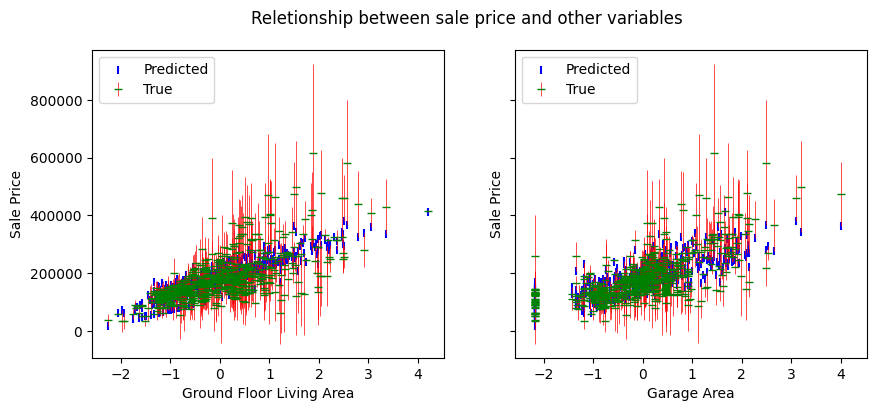

In [64]:
# Generate a plot
# Create container
fig, ax = plt.subplots(1, X_test.shape[1], sharey=True, sharex=True, figsize=(10,4))
fig.suptitle("Reletionship between sale price and other variables")
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Ground Floor Living Area')
ax[1].set_ylabel('Sale Price')
ax[1].set_xlabel('Garage Area')

# Plot data, predicted values, and error bars
for i in range(X_test.shape[1]):
    ax[i].errorbar(X_test[:, i], y_test, yerr=error_bar_values, fmt='_g', ecolor='red', elinewidth=0.5 ,label='True')
    ax[i].scatter(X_test[:,i], y_predictions, c='b', marker='|', label='Predicted')
    ax[i].legend(loc='upper left')

In [71]:
# Print the coefficients
# Print the model intercept and coefficients

print('Intercept: \n', progression_model.intercept_)
print('Coefficients: \n', progression_model.coef_)

print(f'\nSale_Price = s_Gr_Liv_Area * {round(progression_model.coef_[0])} + s_Garage_Area * {round(progression_model.coef_[1])} + {round(progression_model.intercept_)}')
print('Where s_Gr_Liv_Area and s_Garage_Area are standardised variables.')

Intercept: 
 181064.06599908968
Coefficients: 
 [43170.68293337 29770.92010104]

Sale_Price = s_Gr_Liv_Area * 43171 + s_Garage_Area * 29771 + 181064
Where s_Gr_Liv_Area and s_Garage_Area are standardised variables.


**Interpret coefficients in the context of the prediction:**
[Answer here]

**Summarise findings**
[Answer here]